In [1]:
import json
import pandas as pd
import numpy as np

In [2]:
def main(position, dt):
    if dt:
        df = dataframe_position_dt(position)
    else:
        df = dataframe_position_time(position)
    return df

def dataframe_position_dt(position):
    df1 = dataframe_position_version_deltagames(position, version_list[0])
    df2 = dataframe_position_version_deltagames(position, version_list[1])
    frames = [df1, df2]
    df = pd.concat(frames, ignore_index=True)
    df = df.sort_values(by='Games', ascending=False)
    df = dataframe_value(df)
    return df
    
def dataframe_position_time(position):
    df1 = dataframe_time_position_version(time_list[1], position, version_list[0])
    df2 = dataframe_time_position_version(time_list[1], position, version_list[1])
    frames = [df1, df2]
    df = pd.concat(frames, ignore_index=True)
    df = df.sort_values(by='Games', ascending=False)
    df = dataframe_value(df)
    return df

def dataframe_value(df):
    Nsum = np.zeros(len(df.index))
    Pweight = np.zeros(len(df.index))
    Pmin = np.zeros(len(df.index))
    for i in range(len(df.index)):
        namei = df.iat[i, 0]
        Ri = df.iat[i, 1]
        Ni = df.iat[i, 2]
        Pi = df.iat[i, 3]
        Nsum[i] = Ni
        Pweight[i] = Pi * Ni
        Pmin[i] = Pi
        for j in range(i + 1,len(df.index)):
            namej = df.iat[j, 0]
            Rj = df.iat[j, 1]
            Nj = df.iat[j, 2]
            Pj = df.iat[j, 3]
            if namej == namei:
#                 print("%s %s %s %s - %s %s %s %s " % (namei, Ri, Ni, Pi, namej, Rj, Nj, Pj))
                Nsum[i] += Nj
                Pweight[i] += Nj * Pj
                if Pj < Pmin[i] or Pmin[i] == 0:
                    Pmin[i] = Pj
                df.iat[j, 2] = 0
                df.iat[j, 3] = 0
        if Nsum[i] > 0:
            Pweight[i] = Pweight[i] / Nsum[i]
    df.rename(columns={'Price':'Price_weight'}, inplace=True)
    df.rename(columns={'Games':'Games_sum'}, inplace=True)
    df.Games_sum = Nsum
    df.Games_sum = df.Games_sum.astype("int64")
    df.Price_weight = Pweight
    df.Price_weight = df.Price_weight.astype("int64")
    df["Price_min"] = Pmin
    df.Price_min = df.Price_min.astype("int64")
    df["Value"] = value(df.Games_sum, df.Price_weight)
    df = df.sort_values(by='Value', ascending=False)
    df = df.loc[:, ["Name", "Games_sum", "Price_weight", "Price_min", "Value"]]
    return df

def value(games, price):
    P = np.array(price.to_list())
    N = np.array(games.to_list())
    V = (A + (1 - A) / (1 + np.exp(-a * (P - b)))) * (c * N + d)
#     V = V / np.max(V)
    return V

def import_scraped_data(time, position, version):
    filename = "../scraped_data/%s_%s_%s.json" % (time, position, version)
    with open(filename, encoding='utf-8') as json_data:
        d = json.load(json_data)
        json_data.close()
    return pd.DataFrame(d)

def dataframe_time_position_version(time, position, version):
    df = import_scraped_data(time, position, version)
    
    df = df.loc[:, ["Name", "Rating", "Games", "PS4"]]
    df.rename(columns={'PS4':'Price'}, inplace=True)
    df.Name = df.Name.str.replace(r"\(.*\)","")
    df.Rating = pd.to_numeric(df.Rating)
    df.Games = pd.to_numeric(df.Games.str.replace(",",""))
    df.Price = (df.Price.replace(r'[KM]+$', '', regex=True).astype(float) * \
                    df.Price.str.extract(r'[\d\.]+([KM]+)', expand=False)
                    .fillna(1).replace(['K','M'], [10**3, 10**6]).astype(int))
    df.Price = df.Price.astype("int64")
    return df

def dataframe_position_version_deltagames(position, version):
    df0 = dataframe_time_position_version(time_list[0], position, version)
    df1 = dataframe_time_position_version(time_list[1], position, version)
    
    dn = np.zeros(len(df1.index))
    J = np.zeros(len(df1.index))
    i = -1
    for index_df1, row_df1 in df1.iterrows():
        i += 1
        j = -1
        for index_df0, row_df0 in df0.iterrows():
            j += 1
            if J[j] == 1:
                continue
            if row_df1["Name"] == row_df0["Name"] and row_df1["Rating"] == row_df0["Rating"]:
                dn[i] = row_df1["Games"] - row_df0["Games"]
                J[j] = 1
                break
    df1.Games = dn.astype(int)
    return df1

In [9]:
sat = 279000  # price at exponent = satx
satx = 2      # exponent at P = sat
zero = 0.28   # pricevalue at P = 0, price off = 1
zerox = -1    # exponent at P = 0
b = sat/(satx - zerox)
a = satx / (sat - b)
A = (zero * (1 + np.exp(a * b)) -1) / np.exp(a * b)
c = 1         # games off = 0
d = 0         # games off = 1

version_list = ["all_nif", "all_specials"]
position_list = ["GK", "RB,RWB", "LB,LWB", "CB", "CDM,CM,CAM", "RM,RW,RF", "LM,LW,LF", "CF,ST"]
time_list = ["2019121820", "2019122411"]

In [18]:
df = main(position_list[7], True)
df.Value = df.Value.div(df.iat[0, 4])
df.head(60)

,Name,Games_sum,Price_weight,Price_min,Value
30,Wissam Ben Yedder,293021,262295,9400,1.000000
3,Kylian Mbappé,180136,769000,769000,0.712089
1,Heung Min Son,176946,333000,333000,0.651431
12,Roberto Firmino,174367,317237,24000,0.633830
9,Sergio Agüero,136995,394969,85000,0.521941
6,Antoine Griezmann,117954,282671,92000,0.413697
44,Timo Werner,184474,100692,4100,0.385240
11,Lorenzo Insigne,121671,209606,24500,0.376052
14,Cristiano Ronaldo,92683,994000,994000,0.366611
7,Dries Mertens,164756,74452,28750,0.298900


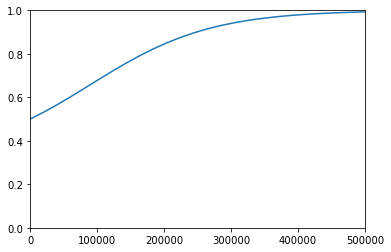

In [44]:
import matplotlib.pyplot as plt
# print("x = 2 at P = %.0f" % (2/a+b))
# print("x = %.0f" % (a*(sat - b)))
# print(df.loc[3,"Value"]-df.loc[2,"Value"])

x = np.linspace(0,1e6)
y = (A + (1 - A) / (1 + np.exp(-a * (x - b))))

plt.plot(x,y)
plt.axis([0, 5e5, 0, 1])
plt.show()